In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft
from scipy import signal
import math
from acoustics.cepstrum import complex_cepstrum
from acoustics.cepstrum import inverse_complex_cepstrum
from scipy.spatial import distance

In [30]:
def idft2(yr, yi):
    N, x = yr.shape[0], []
    yr = dict(yr.values)
    yi = dict(yi.values)
    for t in range(N):
        real = 0
        for (k,v),(k2,v2) in zip(yr.items(),yi.items()):
            theta1 = t * (2 * math.pi) * k
            theta2 = t * (2 * math.pi) * k2
            real += (v * math.cos(theta1)) - (v2 * math.sin(theta2))
        x.append(real/N)
    return x

In [31]:
#Func gives magnitude of FFT provide dataframe in Time Domain
def freq_mag(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data = pd.DataFrame(zip(f,np.abs(yf)),columns=['Freq','Ampli'])
    return fft_data

In [32]:
#Func gives real and imag of FFT provide dataframe in Time Domain
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data1 = pd.DataFrame(zip(f,yf.real),columns=['Freq','Ampli'])
    fft_data2 = pd.DataFrame(zip(f,yf.imag),columns=['Freq','Ampli'])
    return fft_data1,fft_data2

In [33]:
def log_freq(df1, df2):
    df1['Ampli'] = np.log(df1["Ampli"])
    df1['Ampli'] = df1['Ampli'].replace([np.inf, -np.inf], 0)
    df1 = df1.fillna(0)
    df2['Ampli'] = np.log(df2["Ampli"])
    df2['Ampli'] = df2['Ampli'].replace([np.inf, -np.inf], 0)
    df2 = df2.fillna(0)
    return df1, df2

Text(0.5, 1.0, 'Data')

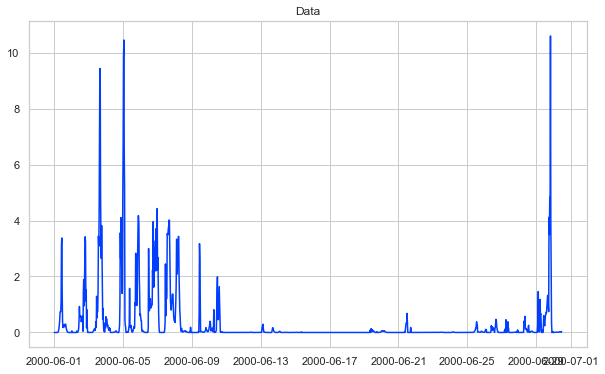

In [34]:
df = pd.read_csv(r"C:\Users\admin\Documents\Algo Asylum\Precipitation_Analysis\preci_all.csv")
df.columns = ['Date','ddate','value','geo']
df['Date'] = df['Date'].astype(str).str[:-2].astype(str)
df['Date'].iloc[43]
df.columns
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d%H%M')
del df['ddate'],df['geo']
#plt.show()
sd = df.loc[(df['Date'].between('2000-06-01 00:00:00', '2000-06-30 11:30:00', inclusive=True))]
#sd['Date'] = pd.to_datetime(sd['Date'])
#y['date'] = y.groupby(y['date'].dt.date).sum()
#sd = sd.iloc[:, 1:]
s = sd['value']
t = sd['Date']
plt.figure(figsize=(10,6))
plt.plot(t, s)
plt.title("Data")

In [35]:
tf = np.arange(sd.shape[0])
signal_1 = pd.DataFrame(zip(tf,s),columns=['Time','Value'])
signal_1

,Time,Value
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
1411,1411,0.026995
1412,1412,0.023328
1413,1413,0.017307
1414,1414,0.034393


## Magnitude of Freq

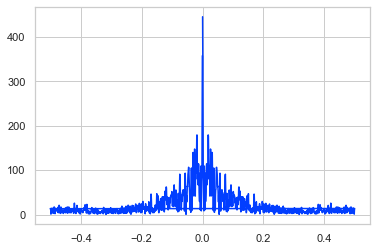

In [36]:
freq_ampli_mag = freq_mag(signal_1)
plt.plot(freq_ampli_mag['Freq'], freq_ampli_mag['Ampli'])

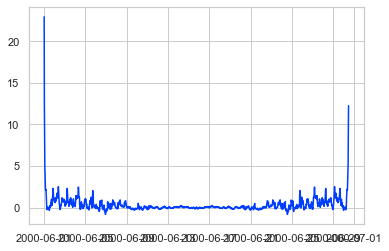

In [37]:
value = list(freq_ampli_mag['Ampli'])
ift = fft.ifft(value)
plt.plot(t,ift)

## Freq on Real and Imag

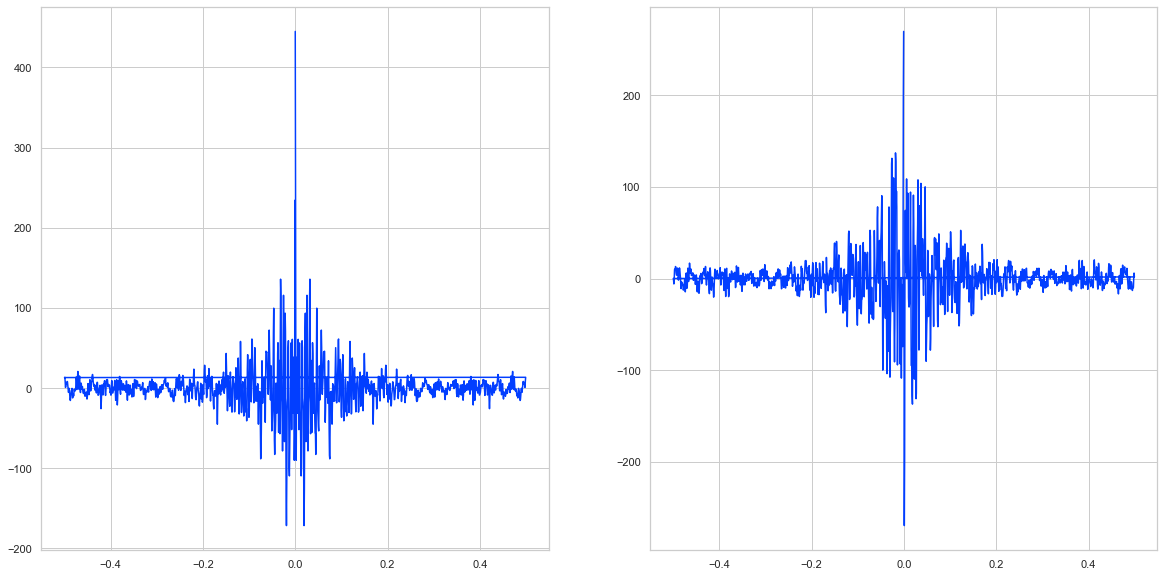

In [38]:
freq_ampli1,freq_ampli1i = freq(signal_1)
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(freq_ampli1['Freq'], freq_ampli1['Ampli'])
axs[1].plot(freq_ampli1i['Freq'], freq_ampli1i['Ampli'])

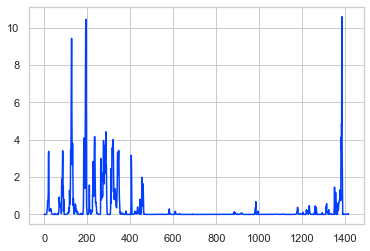

In [39]:
value = idft2(freq_ampli1,freq_ampli1i)
plt.plot(value)

In [40]:
distance.euclidean(signal_1["Value"],value)

1.6054156407673769e-12

Recreating the pattern

## Log Freq

In [41]:
log1, log1i = log_freq(freq_ampli1, freq_ampli1i)

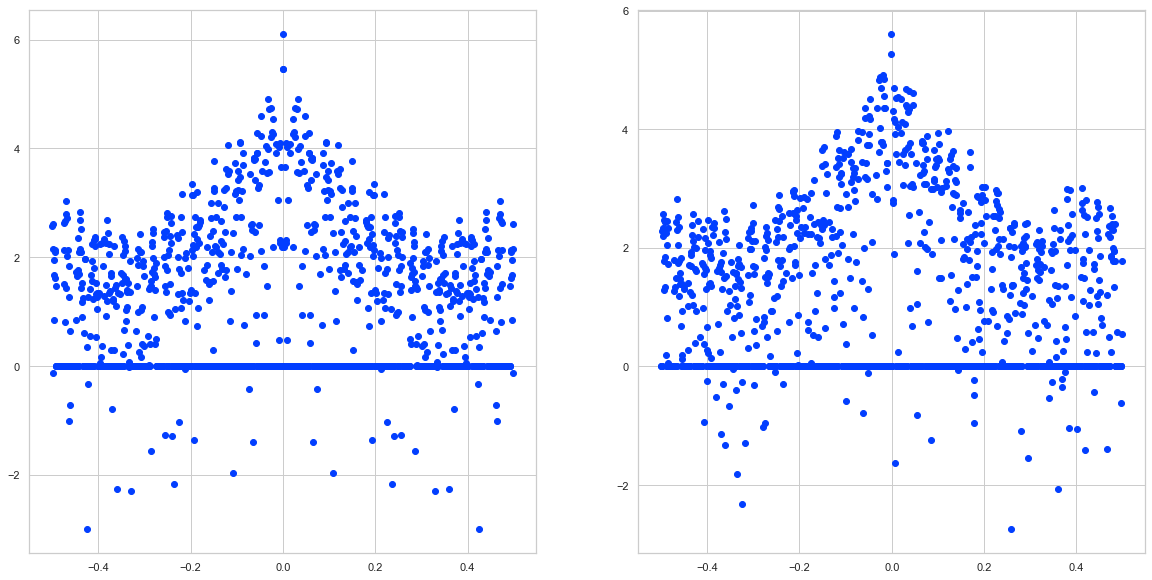

In [42]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(log1['Freq'], log1['Ampli'])
axs[1].scatter(log1i['Freq'], log1i['Ampli'])

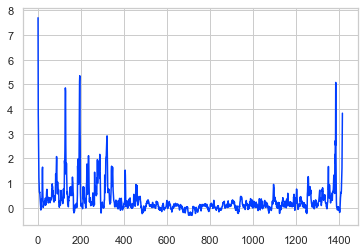

In [43]:
log1["Ampli"] = np.exp(log1["Ampli"])
log1i["Ampli"] = np.exp(log1i["Ampli"])
value = idft2(log1,log1i)
plt.plot(value)

In [44]:
distance.euclidean(signal_1["Value"],value)

22.882320027445296

## Cepstrum

In [45]:
duration = signal_1.shape[0]
fs = 1.0
samples = int(fs*duration)
t = np.arange(samples) / fs
ceps, _ = complex_cepstrum(signal_1['Value'])
print(ceps)

[  2.61340435  20.96351291  -0.65614391 ...  -1.50159832   1.17344534
 -20.06323165]


-118.0


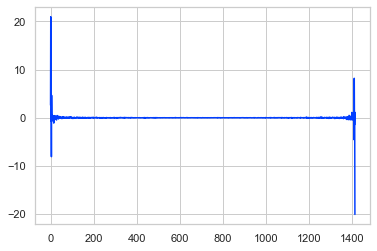

In [46]:
print(_)
plt.plot(t, ceps)

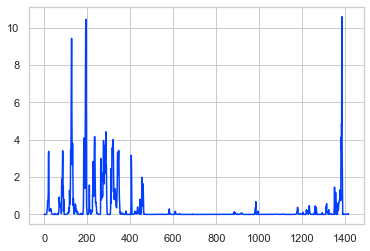

In [47]:
incep = inverse_complex_cepstrum(ceps, np.array(-118.0))    # inverse ceps
plt.plot(signal_1['Time'], incep)

In [48]:
distance.euclidean(signal_1["Value"],incep)

2.356474962461774e-11

# GMM of All

## GMM on Time Series

In [49]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 100)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [50]:
ts = GMM_fit(signal_1)
print(ts, '\n')
print('WEIGHTS -', ts.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', ts.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=14) 

WEIGHTS - [0.05424027 0.06384608 0.09789557 0.03654065 0.04880014 0.26875396
 0.03833352 0.00689235 0.05338267 0.02307426 0.01823193 0.06220764
 0.20492082 0.02288015] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[2.82733601e+02 8.96419628e-01]
 [1.26866717e+03 1.34313949e-02]
 [2.73633513e+02 1.16575161e-03]
 [9.31908464e+01 3.32821464e-01]
 [1.26110728e+03 1.74491106e-01]
 [6.98462102e+02 1.57444728e-04]
 [2.95314989e+02 2.69832275e+00]
 [9.84173383e+02 2.58019128e-01]
 [3.19917457e+02 1.18474558e-01]
 [1.36516542e+02 4.13343375e+00]
 [1.37232001e+03 1.89891853e+00]
 [3.72977309e+02 2.41997720e-02]
 [1.09539305e+03 1.90168158e-04]
 [9.04403209e+02 3.84884270e-02]] 



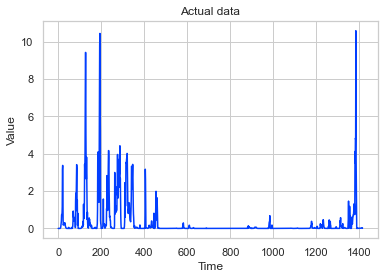

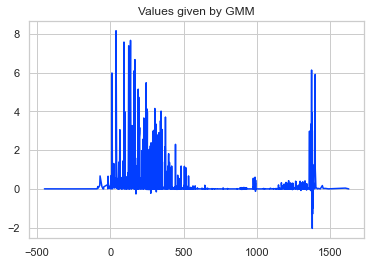

In [51]:
z,_ = ts.sample(signal_1.shape[0])
plt.title('Actual data')
sns.lineplot(signal_1['Time'], signal_1['Value'])
plt.show()
plt.title('Values given by GMM')
sns.lineplot(z[:,0],z[:,1])
plt.show()

In [52]:
distance.euclidean(signal_1["Value"], z[:, 1])

50.60336957908147

## GMM on Real and Img Freq

In [53]:
freq_ampli1,freq_ampli1i = freq(signal_1)

In [54]:
fr = GMM_fit(freq_ampli1)                        # GMM on real part of FFT data
fi = GMM_fit(freq_ampli1i)                      # GMM on imaginary part of FFT data

In [55]:
print(fr, '\n')
print('WEIGHTS -', fr.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',fr.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=9) 

WEIGHTS - [0.43782632 0.02356218 0.02669762 0.00141243 0.07151118 0.00070621
 0.06493297 0.36673271 0.00661836] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[-1.26708950e-03  4.58178389e+00]
 [-3.24357527e-06  7.48724111e+01]
 [ 7.27264919e-07 -6.37305671e+01]
 [ 0.00000000e+00  2.34398694e+02]
 [-1.92708909e-05 -2.83414023e+01]
 [ 0.00000000e+00  4.45011489e+02]
 [ 3.21805981e-05  3.39778720e+01]
 [ 5.48092369e-04 -5.66143754e+00]
 [-1.52144440e-08 -1.23504288e+02]] 



In [56]:
print(fi, '\n')
print('WEIGHTS -', fi.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',fi.means_, '\n')

GaussianMixture(n_components=11) 

WEIGHTS - [0.14787443 0.08774098 0.25690696 0.01229875 0.10410167 0.00420961
 0.04134351 0.32180296 0.00141243 0.00070621 0.02160248] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 1.84033754e-01 -4.80925491e+00]
 [ 1.81191187e-02  2.83330663e+01]
 [ 3.44365597e-01  1.67743679e+00]
 [-1.11159318e-02 -1.01366638e+02]
 [-1.43932117e-01 -1.58248410e+01]
 [-1.91215546e-02  1.36887618e+02]
 [-3.22798316e-02 -4.56520831e+01]
 [-3.14018536e-01  1.50125899e+00]
 [ 1.05932204e-03 -2.32008713e+02]
 [-7.06214689e-04  2.69684245e+02]
 [-1.86391533e-03  7.65481421e+01]] 



In [57]:
z1,_ = fr.sample(freq_ampli1.shape[0])
z1i,_ = fi.sample(freq_ampli1i.shape[0])

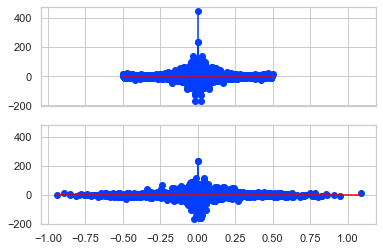

In [58]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].stem(freq_ampli1['Freq'], freq_ampli1['Ampli'])
#plt.show()
ax[1].stem(z1[:, 0], z1[:, 1])
plt.show()

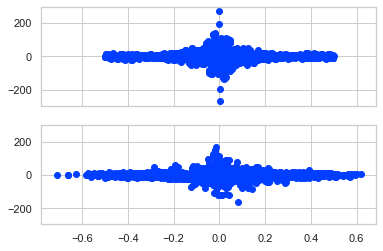

In [59]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli1i['Freq'], freq_ampli1i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

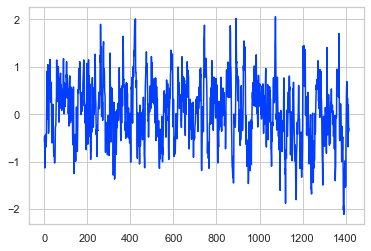

In [60]:
fr_d = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])
fi_d = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])
value = idft2(fr_d,fi_d)
plt.plot(value)

In [61]:
distance.euclidean(signal_1["Value"], value)

45.95353629310131

## GMM on Log-Freq

In [62]:
lr = GMM_fit(log1)                        # GMM on real part of FFT data
li = GMM_fit(log1i)

In [63]:
print(lr, '\n')
print('WEIGHTS -', lr.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',lr.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=10) 

WEIGHTS - [0.09408245 0.00141243 0.50842332 0.00070621 0.02605003 0.00141243
 0.02728372 0.00565097 0.30823115 0.0267473 ] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[-5.11428874e-03  1.21664411e+01]
 [ 5.37765507e-16  1.35931241e+02]
 [-3.21763418e-08  9.99992768e-01]
 [ 0.00000000e+00  4.45011489e+02]
 [ 5.82174404e-07  5.85170721e+01]
 [ 0.00000000e+00  2.34398694e+02]
 [-8.32995423e-06  3.76277708e+01]
 [-2.94414010e-10  1.05614727e+02]
 [ 3.93268675e-04  4.60390296e+00]
 [ 2.64261500e-04  2.40972371e+01]] 



In [64]:
print(li, '\n')
print('WEIGHTS -', li.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',li.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=8) 

WEIGHTS - [0.50066163 0.02075828 0.06125901 0.00070621 0.00331715 0.36098637
 0.05160513 0.00070621] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 1.55465230e-02  1.00000000e+00]
 [ 1.50927835e-03  7.82099345e+01]
 [ 5.99702163e-02  1.85510777e+01]
 [-7.06214689e-04  2.69684245e+02]
 [-2.22945147e-02  1.27211628e+02]
 [-3.26679438e-02  5.58725886e+00]
 [ 5.12191940e-04  3.57718178e+01]
 [-1.41242938e-03  1.94333181e+02]] 



In [65]:
z2,_ = lr.sample(log1.shape[0])
z2i,_ = li.sample(log1i.shape[0])

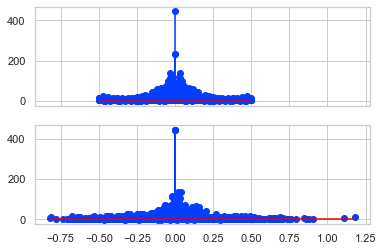

In [66]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].stem(log1['Freq'], log1['Ampli'])
#plt.show()
ax[1].stem(z2[:, 0], z2[:, 1])
plt.show()

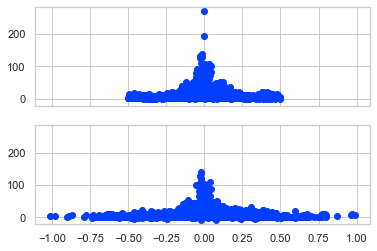

In [67]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(log1i['Freq'], log1i['Ampli'])
#plt.show()
ax[1].scatter(z2i[:, 0], z2i[:, 1])
plt.show()

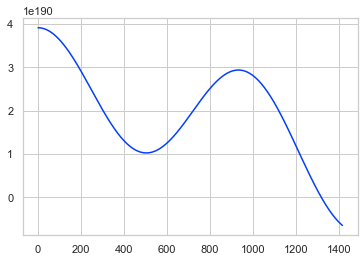

In [68]:
lr_d = pd.DataFrame(zip(z2[:,0],np.exp(z2[:,1])),columns=['Freq','Ampli'])
li_d = pd.DataFrame(zip(z2i[:,0],np.exp(z2i[:,1])),columns=['Freq','Ampli'])
value = idft2(lr_d,li_d)
plt.plot(value)

In [69]:
distance.euclidean(signal_1["Value"],value)

8.374709975107485e+191

## GMM on Cepstrum

In [70]:
c1 = np.array(ceps).reshape(-1, 1)
c = GMM_fit(c1)

In [71]:
print(c, '\n')
print('WEIGHTS -', c.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', c.means_, '\n')

GaussianMixture(n_components=10) 

WEIGHTS - [7.57739363e-01 7.06214689e-04 7.06214689e-04 7.06214689e-04
 7.06214689e-04 7.06212984e-04 7.06214689e-04 2.00245534e-01
 7.06214689e-04 3.70716024e-02] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[-2.32913891e-04]
 [ 2.09635129e+01]
 [-2.00632317e+01]
 [ 8.19066041e+00]
 [-8.08390495e+00]
 [ 2.61340435e+00]
 [-4.55839379e+00]
 [ 6.26609246e-03]
 [ 4.65550249e+00]
 [ 1.62635284e-02]] 



In [76]:
z3,_ = c.sample(t.shape[0])

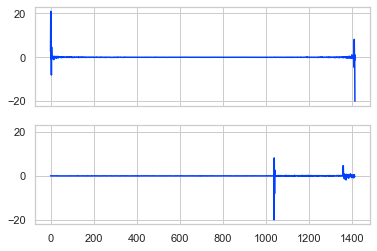

In [77]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].plot(t, ceps)
#plt.show()
ax[1].plot(t, z3.flatten())
plt.show()

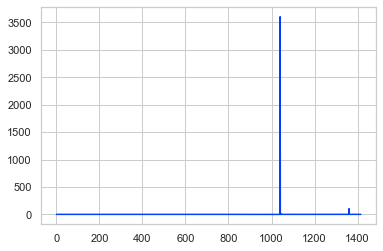

In [80]:
gmm_incep = inverse_complex_cepstrum(z3, np.array(-118.0))    # inverse ceps
plt.plot(signal_1['Time'], gmm_incep)

In [81]:
distance.euclidean(signal_1['Value'], gmm_incep)

3607.5868108903296